<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/Lstm_Predictive_maintenance_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:


import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM


##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [220]:
df =pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /31_hidrolikmotoru_analiz.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [221]:
df.drop(["name","partno","balancerbasinci","spm","xkurt"],axis=1,inplace=True)
df.columns=['Time', 'vibx', 'vibz', 'temp', 'zacc', 'zfreq', 'crest']
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]

df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split()[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S

df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,zfreq,crest
0,2020-01-01,0.588430,0.489543,21.010227,0.159783,0.037760,4.590732
1,2020-01-03,1.008986,0.982548,29.085213,0.255672,0.064294,4.027926
2,2020-01-04,0.983633,0.897994,30.191087,0.255289,0.062603,4.134363
3,2020-01-05,0.605476,0.514866,23.518047,0.158782,0.038718,4.042531
4,2020-01-06,1.067184,0.924652,29.734194,0.283885,0.067874,4.291912


In [222]:
#for feature in df.columns[1:7]: 
 #   df[feature]=np.log(df[feature])

In [223]:

#df['Hour'] = df['Time'].apply(lambda time: time.hour)
#df['Month'] = df['Time'].apply(lambda time: time.month)
#df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
#df['Year'] = df['Time'].apply(lambda t: t.year)
#df["Week"] = df['Time'].apply(lambda t: t.week)

#df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)



In [224]:
#for col in df.columns[1:7]:
 # for i in [1,2,3,4,5]:
  #    df['lag_'+str(i)+col] = df[col].shift(i)

In [225]:
#for col in df.columns[1:7]:
 # df[col+'expanding_mean_5'] = df[col].expanding(7).mean()
  #df[col+'expanding_std_5'] = df[col].expanding(7).std()
#df.dropna(axis=0,inplace=True)
#df.reset_index(drop=True,inplace=True)

In [226]:
#ariza_tarihleri=["2020-01-27 14:00:00","2020-09-11 14:00:00","2020-10-06 18:00:00","2020-10-10 08:00:00","2020-10-13 04:00:00","2020-10-18 00:00:00","2020-10-30 09:00:00","2020-11-02 05:00:00"]
ariza_tarihleri=["2020-01-27","2020-09-11","2020-10-06","2020-10-10","2020-10-13","2020-10-18","2020-10-30","2020-11-02"]

In [227]:
df

,Time,vibx,vibz,temp,zacc,zfreq,crest
0,2020-01-01,0.588430,0.489543,21.010227,0.159783,0.037760,4.590732
1,2020-01-03,1.008986,0.982548,29.085213,0.255672,0.064294,4.027926
2,2020-01-04,0.983633,0.897994,30.191087,0.255289,0.062603,4.134363
3,2020-01-05,0.605476,0.514866,23.518047,0.158782,0.038718,4.042531
4,2020-01-06,1.067184,0.924652,29.734194,0.283885,0.067874,4.291912
...,...,...,...,...,...,...,...
358,2021-01-18,1.805291,1.343914,34.741699,0.754880,0.143463,5.219309
359,2021-01-19,1.864468,1.384201,31.716146,0.822474,0.150607,5.455394
360,2021-01-20,1.653013,1.228412,33.654478,0.673472,0.131848,5.146100
361,2021-01-21,1.572600,1.176131,36.674999,0.621676,0.123443,5.045110


In [228]:

df["rul"]=[np.nan for i in df.index]

onceki_ariza = 0
for i in range(len(ariza_tarihleri)):
  ariza=ariza_tarihleri[i]
  if onceki_ariza!=0:
    onceki_ariza = ariza_tarihleri[i-1]
  else:
    onceki_ariza ="2020-01-01"
  rul=[i for i in range(len(df.loc[df[df["Time"]==onceki_ariza].index[0]:df[df["Time"]==ariza].index[0]-1,"rul"].tolist()))]
  rul.reverse()
  df.loc[df[df["Time"]==onceki_ariza].index[0]:df[df["Time"]==ariza].index[0]-1,"rul"]= rul

In [229]:

import scipy.stats as stat
import pylab
def plot_data(df,feature):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    plt.title(feature)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()

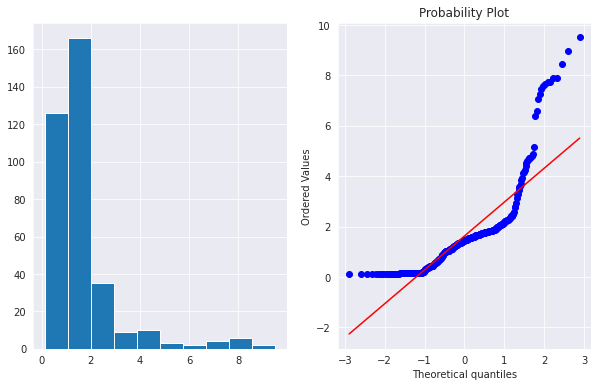

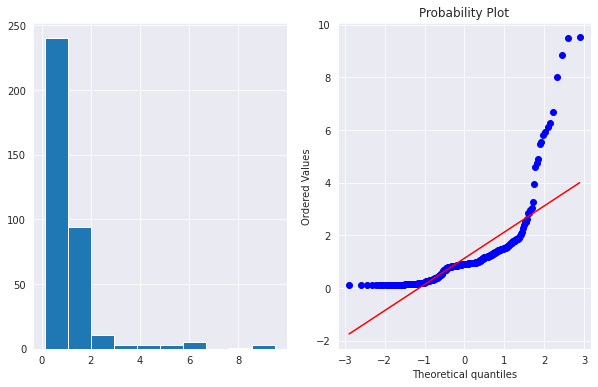

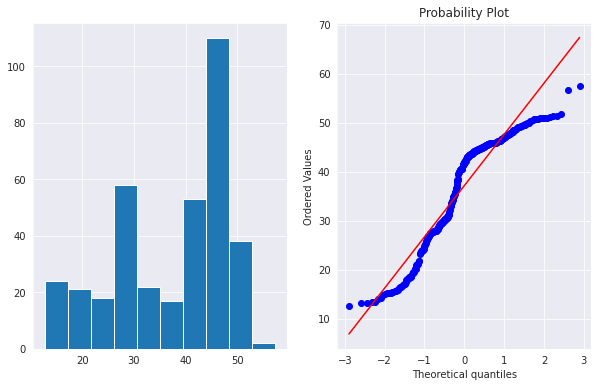

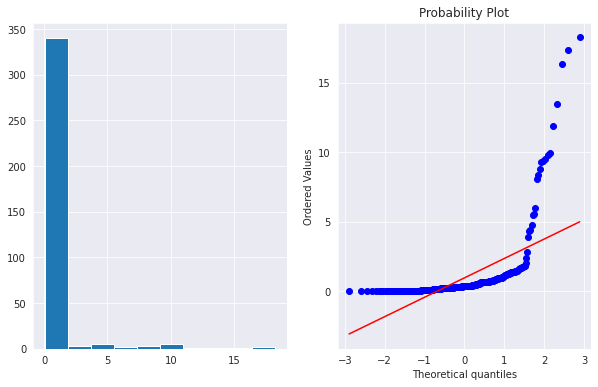

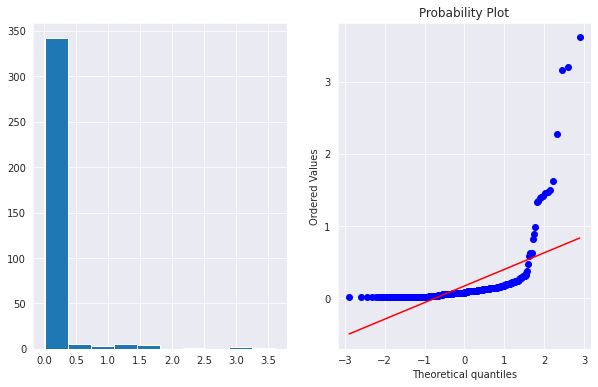

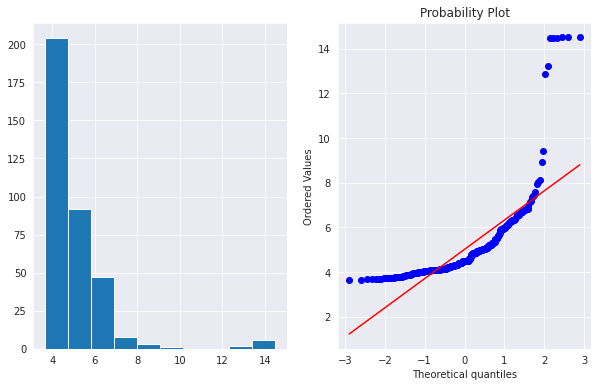

In [230]:
for feature in df.columns[1:7]:
    plot_data(df,feature)

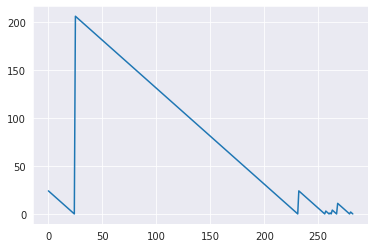

In [231]:

df["rul"].plot()

In [232]:
df.isna().sum()

Time      0
vibx      0
vibz      0
temp      0
zacc      0
zfreq     0
crest     0
rul      80
dtype: int64

In [233]:
label = []
for i in df["rul"]:
  if i<8:
    label.append(1)
  else:
    label.append(0)
df["label"]=label

In [234]:
label_window="label"

In [235]:
train_df=df[(df["Time"]<="2020-10-13") & (df["Time"]>"2020-01-01")]
test_df = df[df["Time"]>"2020-09-20"]

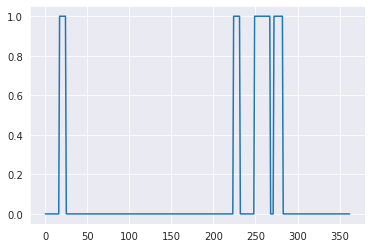

In [236]:
df["label"].plot()

In [237]:
train_df

,Time,vibx,vibz,temp,zacc,zfreq,crest,rul,label
1,2020-01-03,1.008986,0.982548,29.085213,0.255672,0.064294,4.027926,23.0,0
2,2020-01-04,0.983633,0.897994,30.191087,0.255289,0.062603,4.134363,22.0,0
3,2020-01-05,0.605476,0.514866,23.518047,0.158782,0.038718,4.042531,21.0,0
4,2020-01-06,1.067184,0.924652,29.734194,0.283885,0.067874,4.291912,20.0,0
5,2020-01-07,1.092764,0.972984,28.866409,0.256283,0.068015,3.870108,19.0,0
...,...,...,...,...,...,...,...,...,...
259,2020-10-08,7.666629,5.823483,48.645372,9.968416,1.459271,6.820000,1.0,1
260,2020-10-09,7.570013,4.761209,47.554823,11.921055,1.627877,7.166969,0.0,1
261,2020-10-10,4.165119,2.500341,45.916776,4.401576,0.628648,6.824733,1.0,1
262,2020-10-12,3.560047,1.796384,46.355318,2.820063,0.378455,7.369810,0.0,1


In [238]:
def pickle_all(key,value):
         pickle_out = open(key, "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()

In [239]:
# MinMax normalization (from 0 to 1)
import pickle
cols_normalize = train_df.columns.difference(['Time','rul',"label"])
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
pickle_all(f"/content/drive/MyDrive/model_predictive_maintanence/scaler_classification_1_week.pkl",min_max_scaler)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#Test


norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [240]:

train_df

,Time,vibx,vibz,temp,zacc,zfreq,crest,rul,label
1,2020-01-03,0.106008,0.130624,0.424992,0.018555,0.033561,0.034994,23.0,0
2,2020-01-04,0.102964,0.117693,0.453587,0.018523,0.032516,0.044803,22.0,0
3,2020-01-05,0.057559,0.059104,0.281039,0.010403,0.017753,0.036340,21.0,0
4,2020-01-06,0.112996,0.121770,0.441773,0.020929,0.035774,0.059321,20.0,0
5,2020-01-07,0.116067,0.129161,0.419334,0.018606,0.035861,0.020451,19.0,0
...,...,...,...,...,...,...,...,...,...
259,2020-10-08,0.905381,0.870921,0.930768,0.835718,0.895786,0.292285,1.0,1
260,2020-10-09,0.893781,0.708473,0.902570,1.000000,1.000000,0.324258,0.0,1
261,2020-10-10,0.484960,0.362731,0.860214,0.367363,0.382384,0.292721,1.0,1
262,2020-10-12,0.412310,0.255079,0.871553,0.234305,0.227742,0.342950,0.0,1


In [241]:
test_df

,Time,vibx,vibz,temp,zacc,zfreq,crest,rul,label
0,2020-09-21,0.454564,0.305963,0.826066,0.139965,0.171445,0.213467,14.0,0
1,2020-09-22,0.445601,0.296175,0.820908,0.128882,0.166207,0.182697,13.0,0
2,2020-09-23,0.417014,0.270137,0.822378,0.119678,0.167098,0.145477,12.0,0
3,2020-09-24,0.339219,0.210145,0.826014,0.103967,0.144358,0.145521,11.0,0
4,2020-09-25,0.359512,0.255754,0.915067,0.198716,0.205475,0.267317,10.0,0
...,...,...,...,...,...,...,...,...,...
116,2021-01-18,0.201619,0.185885,0.571254,0.060555,0.082495,0.144781,NaN,0
117,2021-01-19,0.208724,0.192046,0.493021,0.066242,0.086911,0.166536,NaN,0
118,2021-01-20,0.183335,0.168222,0.543141,0.053706,0.075315,0.138035,NaN,0
119,2021-01-21,0.173680,0.160227,0.621245,0.049348,0.070120,0.128728,NaN,0


In [242]:
# pick  window size 
sequence_length = 16

# function to reshape features into (samples, time steps, features)

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sequence_cols=train_df.columns.difference(['Time','rul',"label",])

# generator for the sequences
#seq_gen=(list(gen_sequence(train_df[train_df.index==id], sequence_length, sequence_cols))  for id in train_df.index)
seq_gen = list(list(gen_sequence(train_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array.shape)


(247, 16, 6)


In [243]:
train_df

,Time,vibx,vibz,temp,zacc,zfreq,crest,rul,label
1,2020-01-03,0.106008,0.130624,0.424992,0.018555,0.033561,0.034994,23.0,0
2,2020-01-04,0.102964,0.117693,0.453587,0.018523,0.032516,0.044803,22.0,0
3,2020-01-05,0.057559,0.059104,0.281039,0.010403,0.017753,0.036340,21.0,0
4,2020-01-06,0.112996,0.121770,0.441773,0.020929,0.035774,0.059321,20.0,0
5,2020-01-07,0.116067,0.129161,0.419334,0.018606,0.035861,0.020451,19.0,0
...,...,...,...,...,...,...,...,...,...
259,2020-10-08,0.905381,0.870921,0.930768,0.835718,0.895786,0.292285,1.0,1
260,2020-10-09,0.893781,0.708473,0.902570,1.000000,1.000000,0.324258,0.0,1
261,2020-10-10,0.484960,0.362731,0.860214,0.367363,0.382384,0.292721,1.0,1
262,2020-10-12,0.412310,0.255079,0.871553,0.234305,0.227742,0.342950,0.0,1


In [244]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df, sequence_length, ['label'])]
label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(247, 1)


In [245]:
model_path_label1 = "/content/drive/MyDrive/model_predictive_maintanence/classification_label_1_week_model.h5"


In [246]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=50, batch_size=10, validation_split=0.0005, verbose=2)
model.save(model_path_label1)
# list all data in history
print(history.history.keys())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 16, 100)           42800     
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 100)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
25/25 - 4s - loss: 0.4963 - accuracy: 0.8780 - val_loss: 1.3437 - val_accuracy: 0.0000e+00
Epoch 2/5

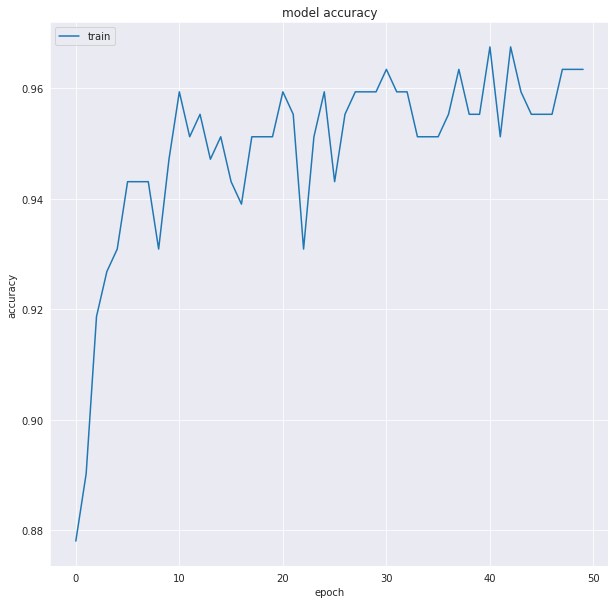

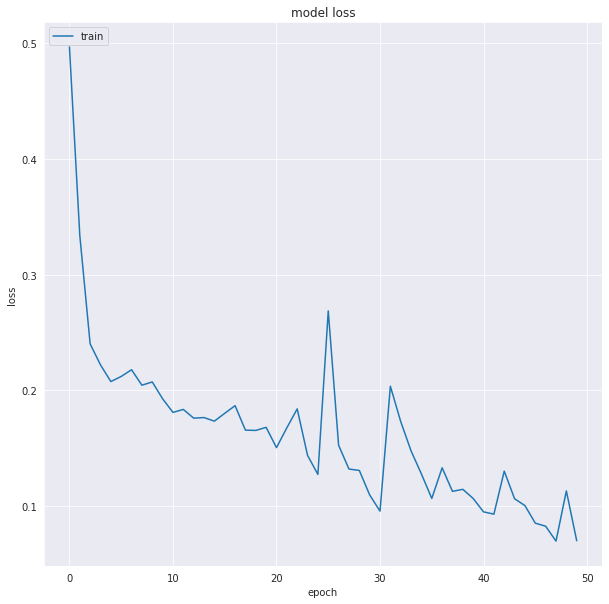

2/2 [==============================] - 0s 20ms/step - loss: 0.0632 - accuracy: 0.9636
Accurracy: 0.9635627269744873


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25/25 [==============================] - 1s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[215   1]
 [  8  23]]
Precision: [0.96412556 0.95833333]
recall =  [0.99537037 0.74193548]


In [247]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=10)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
print("Precision:",precision_score(y_true, y_pred, average=None)) 
recall = recall_score(y_true, y_pred, average=None)
print(  'recall = ', recall)

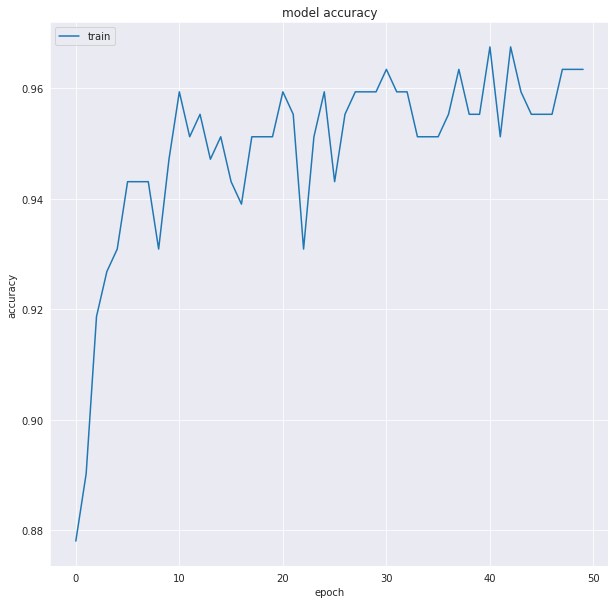

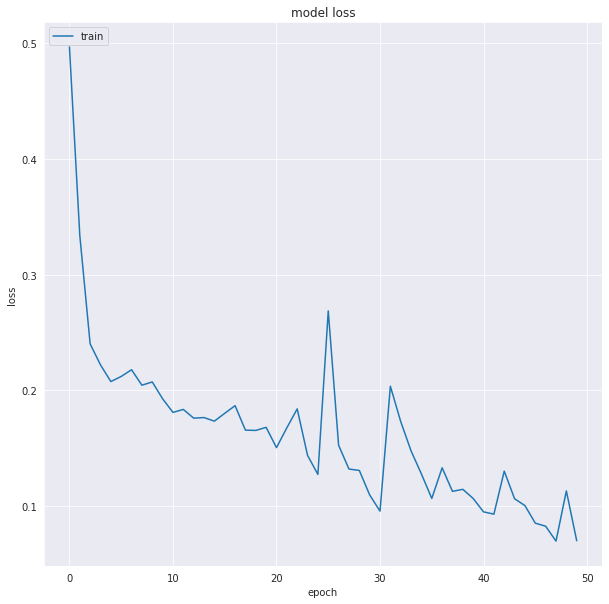

2/2 [==============================] - 0s 14ms/step - loss: 0.0632 - accuracy: 0.9636
Accurracy: 0.9635627269744873
25/25 [==============================] - 0s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[215   1]
 [  8  23]]
Precision: [0.96412556 0.95833333]
recall =  [0.99537037 0.74193548]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [248]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=10)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
print("Precision:",precision_score(y_true, y_pred, average=None)) 
recall = recall_score(y_true, y_pred, average=None)
print(  'recall = ', recall)

In [249]:
# pick the feature columns 
sequence_cols=train_df.columns.difference(['Time','rul',"label"])

# generator for the sequences

seq_gen = list(list(gen_sequence(test_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array_test_last=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array_test_last.shape) 

(105, 16, 6)


In [250]:
# generate labels
label_gen = [gen_labels(test_df, sequence_length, ['label'])]
label_array_test_last = np.concatenate(label_gen).astype(np.float32)
print(label_array_test_last.shape)

(105, 1)


4/4 - 1s - loss: 0.3311 - accuracy: 0.9524
Accurracy: 0.9523809552192688


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[79  5]
 [ 0 21]]
Precision:  0.8076923076923077 
 Recall:  1.0 
 F1-score: 0.8936170212765957


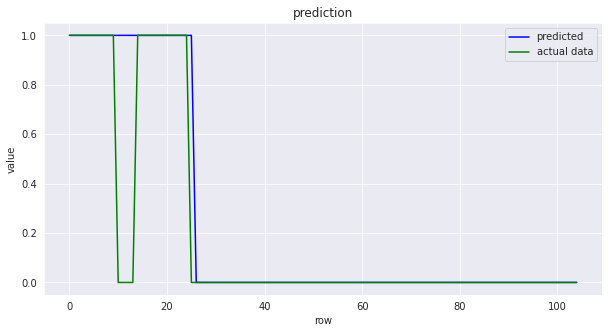

In [251]:

import os
# if best iteration's model was saved then load and use it
estimator = load_model(model_path_label1)
# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper right')
plt.show()
fig_verify.savefig("model_verify.png")

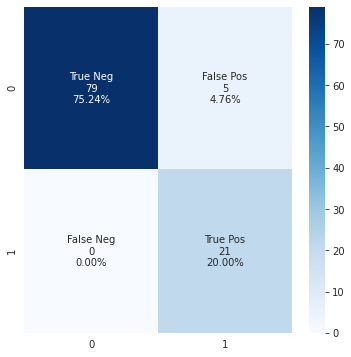

In [252]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.set_style("darkgrid")

cf_matrix1 = np.array([[cm[0][0], cm[0][1]],
                                   [cm[1][0], cm[1][1]]])
group_names1 = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts1 = ["{0:0.0f}".format(value) for value in cf_matrix1.flatten()]
group_percentages1 = ["{0:.2%}".format(value) for value in cf_matrix1.flatten() / np.sum(cf_matrix1)]
labels1 = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names1, group_counts1, group_percentages1)]
labels1 = np.asarray(labels1).reshape(2, 2)
sns.heatmap(cf_matrix1, annot=labels1, fmt="", cmap='Blues')